# Linear regression

In statistics, linear regression is a **linear approach to modelling the relationship between a scalar response and one or more explanatory variables (also known as dependent and independent variables)**. The case of one explanatory variable is called simple linear regression; for more than one, the process is called multiple linear regression (from [Wikipedia](https://en.wikipedia.org/wiki/Linear_regression)).

Given a data set ${\displaystyle \{y_{i},\,x_{i1},\ldots ,x_{ip}\}_{i=1}^{n}}$ of n statistical units, a linear regression model assumes that the relationship between the dependent variable y and the p-vector of regressors x is linear. This relationship is modeled through a disturbance term or error variable ε — an unobserved random variable that adds "noise" to the linear relationship between the dependent variable and regressors. 

Thus the model takes the form:

${\displaystyle y_{i}=\beta _{0}+\beta _{1}x_{i1}+\cdots +\beta _{p}x_{ip}+\varepsilon _{i}=\mathbf {x} _{i}^{\mathsf {T}}{\boldsymbol {\beta }}+\varepsilon _{i},\qquad i=1,\ldots ,n,}$

where T denotes the transpose, so that ${x} _{i}^{\mathsf {T}}{\boldsymbol {\beta }}$ is the inner product between vectors $\mathbf {x} _{i}$ and ${\boldsymbol {\beta }}$.

Usually a constant is included as one of the regressors. In particular, ${\displaystyle \mathbf {x} _{i0}=1}$ for ${\displaystyle i=1,\ldots ,n}$. The corresponding element of β is called the intercept. Many statistical inference procedures for linear models require an intercept to be present, so it is often included even if theoretical considerations suggest that its value should be zero.

Fitting a linear model to a given data set usually requires estimating the regression coefficients ${\displaystyle {\boldsymbol {\beta }}}$ such that the error term ${\displaystyle {\boldsymbol {\varepsilon }}=\mathbf {y} -X{\boldsymbol {\beta }}}$ is minimized. 

In [1]:
import numpy as np
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

sns.set(context = "talk", 
        style = "white", 
        palette = "husl",
        rc={'figure.figsize':(10, 6)})

## Simulating data (1 predictor)

In [2]:
sample_size = 30
x = np.random.normal(0, 1, sample_size) # IV
error_term = 1
generating_betas = [.2, .6]
noise = np.random.normal(0, error_term, sample_size)
X = sm.add_constant(x)
y = np.sum(generating_betas*X, axis=1) + noise

/Users/laurafontanesi/miniconda3/envs/stanenv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


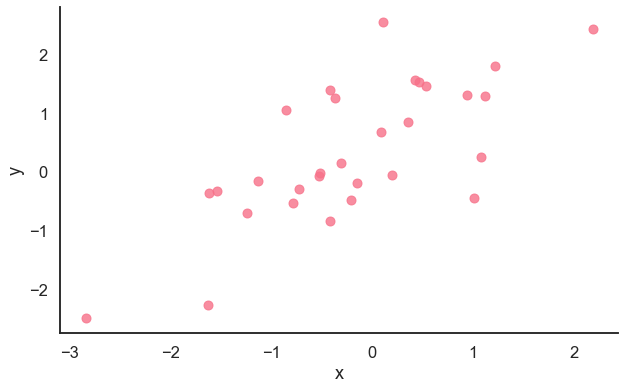

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x, y, fit_reg=False)
plt.xlabel("x")
plt.ylabel("y")
sns.despine();

In [4]:
model_code = """

data {
    int<lower=0> N;   // number of data items
    int<lower=0> K;   // number of coefficients (1 + n predictors)
    matrix[N, K] X;   // predictor matrix
    vector[N] y;      // outcome vector
}
parameters {
    vector[K] beta;       // regression coefficients
    real<lower=0> sigma;  // error scale
}
model {
    beta ~ cauchy(0, 5);          // prior coefficients
    sigma ~ cauchy(0, 5);         // prior error term
    y ~ normal(X * beta, sigma);  // likelihood
}

generated quantities {
    vector[N] log_likelihood;
    vector[N] y_hat;
    
    {for (i in 1:N) {
        log_likelihood[i] = normal_lpdf(y[i] | X[i]*beta, sigma);      // log likelihood of each data point y[i] 
        y_hat[i] = normal_rng(X[i]*beta, sigma);                       // generated data for each sample p
    }
    }
}
"""

In [5]:
data_dict = {'N': sample_size,
             'K': 2,
             'X': X,
             'y': y}

n_iter = 3000
n_warmup = 1000
n_chains = 2

In [6]:
import pystan

In [7]:
fit = pystan.stan(model_code=model_code, 
                  data=data_dict,
                  iter=n_iter, 
                  warmup=n_warmup,
                  chains=n_chains)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a57c4b6a90faf085854c2151217af6cd NOW.


In [8]:
import arviz as az

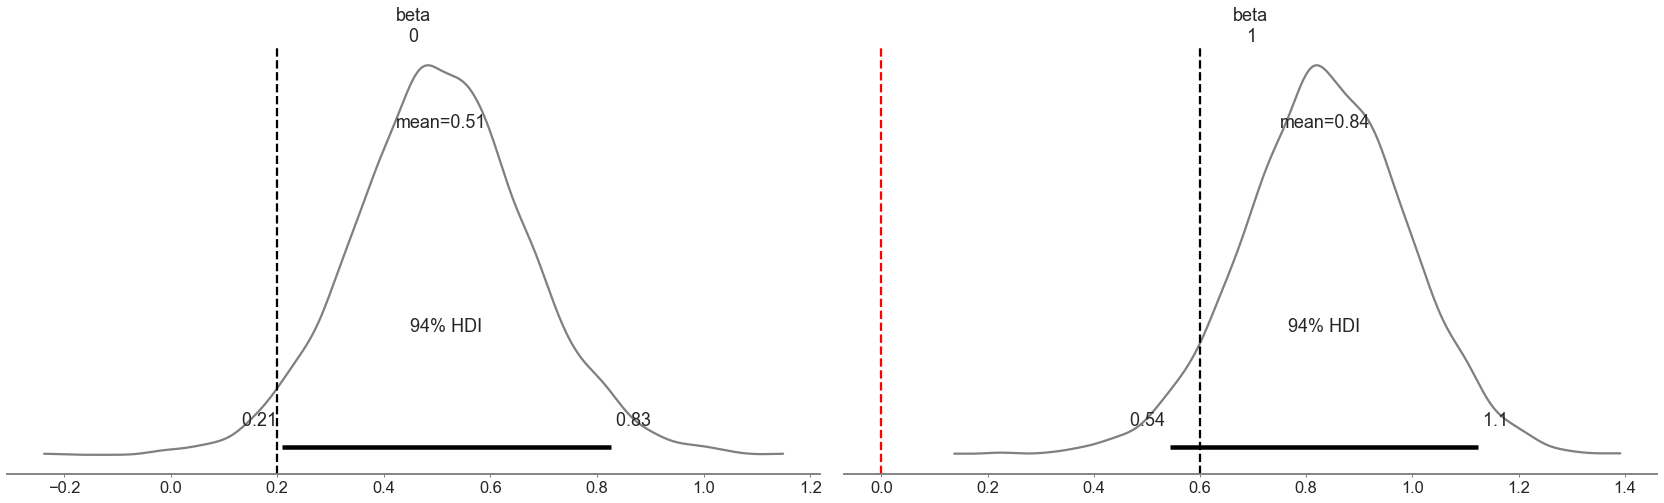

In [9]:
g = az.plot_posterior(fit, var_names=["beta"], color='grey');

g[0].axvline(generating_betas[0], color='k', linestyle='--');
g[1].axvline(generating_betas[1], color='k', linestyle='--');
g[1].axvline(0, color='red', linestyle='--');

**ON YOUR OWN:** Now try to add another predictor (e.g., `x = np.random.normal(0, 1, (sample_size, 2))` with coefficient $\beta$=.1. Rerun the model. What do you observe?

## Real data

Download the **Vehicle dataset** (`Car details v3.csv`) from https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho

In [11]:
import pandas as pd
data = pd.read_csv('/Users/laurafontanesi/git/bayesian_est_workshop/data/Car details v3.csv')
# only keep 1000 data:
data = data.sample(frac=1).reset_index(drop=True)
data = data.loc[:500,:] 
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift VXI Optional,2016,450000,64000,Petrol,Individual,Manual,First Owner,20.4 kmpl,1197 CC,81.80 bhp,113Nm@ 4200rpm,5.0
1,Honda WR-V i-DTEC VX,2019,1000000,72000,Diesel,Individual,Manual,First Owner,25.5 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0
2,Hyundai Verna 1.6 CRDi EX AT,2013,525000,75000,Diesel,Individual,Automatic,First Owner,22.32 kmpl,1582 CC,126.3 bhp,259.9Nm@ 1900-2750rpm,5.0
3,Chevrolet Sail 1.2 LS ABS,2016,550000,15000,Petrol,Individual,Manual,First Owner,18.2 kmpl,1199 CC,82.4 bhp,108.5Nm@ 5000rpm,5.0
4,Maruti SX4 Vxi BSIII,2009,250000,125876,Petrol,Individual,Manual,Second Owner,15.0 kmpl,1586 CC,104.68 bhp,"145@ 4,100(kgm@ rpm)",5.0


In [12]:
data.shape

(501, 13)

/Users/laurafontanesi/miniconda3/envs/stanenv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


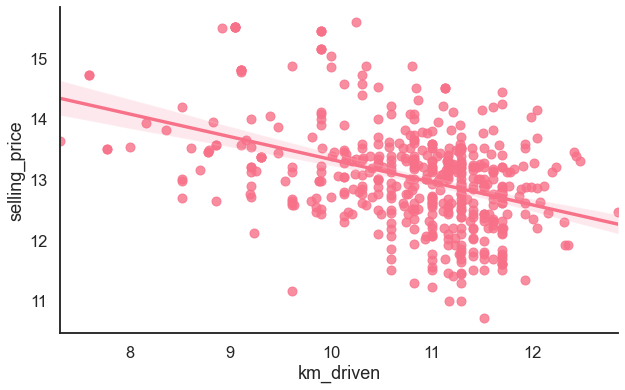

In [13]:
# log transform very skewed data:
sns.regplot(np.log(data['km_driven']), np.log(data['selling_price']))
sns.despine();

/Users/laurafontanesi/miniconda3/envs/stanenv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


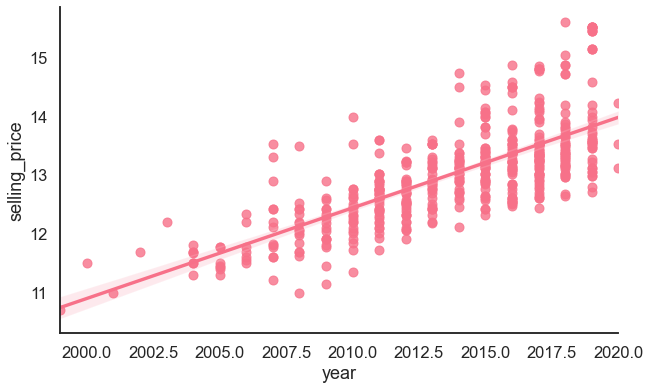

In [14]:
# log transform very skewed data:
sns.regplot(data['year'], np.log(data['selling_price']))
sns.despine();

In [15]:
sample_size = data.shape[0]
x = data[['km_driven', 'year']].values
x[:, 0] = np.log(x[:, 0]) # log transform km driven
X = sm.add_constant(x)
y = np.log(data['selling_price']) # log transform selling price

In [16]:
data_dict = {'N': sample_size,
             'K': 3,
             'X': X,
             'y': y}

n_iter = 4000
n_warmup = 1000
n_chains = 2

In [17]:
fit = pystan.stan(model_code=model_code, 
                  data=data_dict,
                  iter=n_iter, 
                  warmup=n_warmup,
                  chains=n_chains)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a57c4b6a90faf085854c2151217af6cd NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


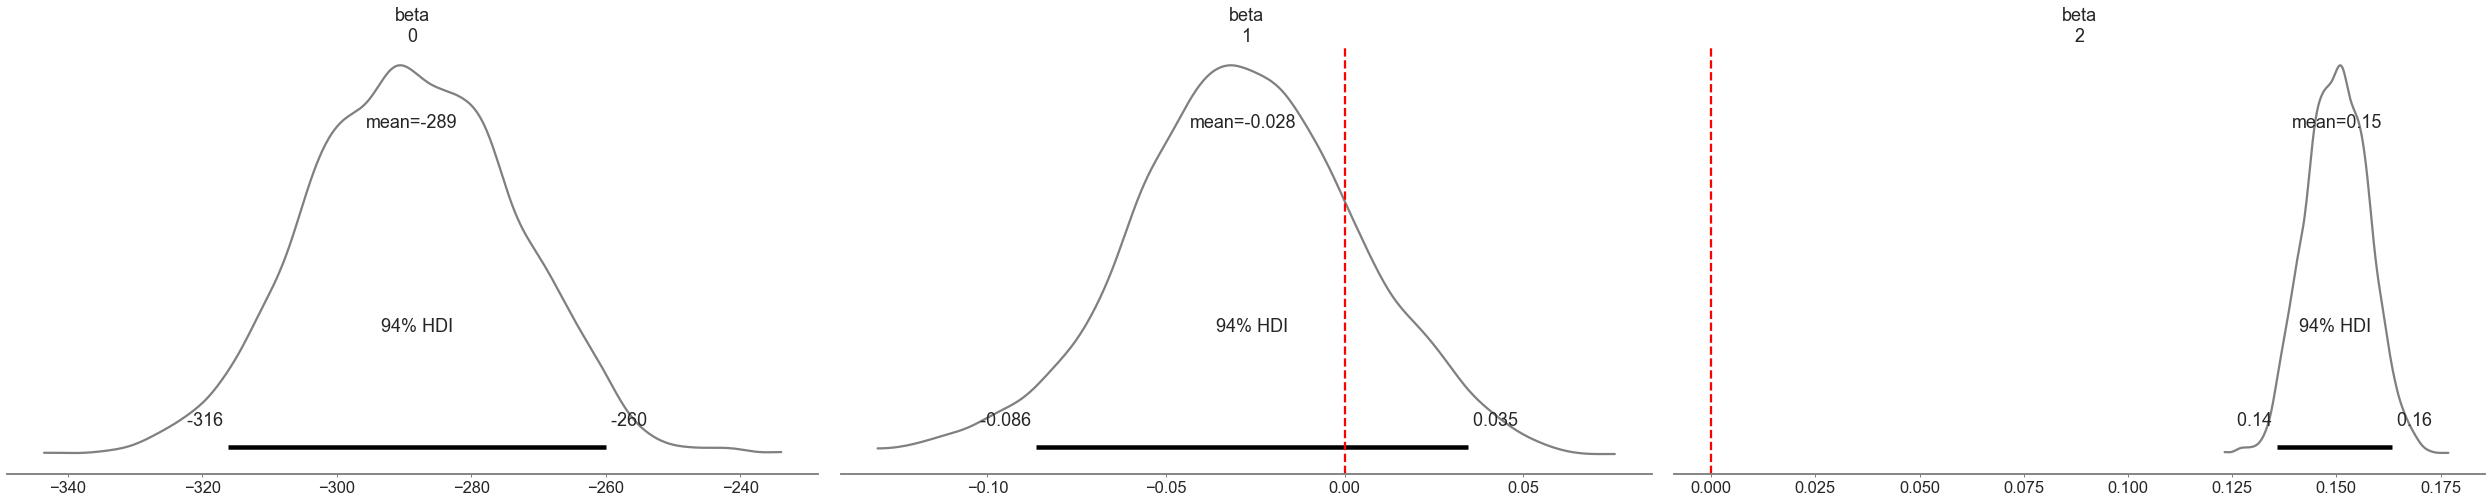

In [18]:
g = az.plot_posterior(fit, var_names=["beta"], color='grey');

g[1].axvline(0, color='red', linestyle='--')
g[2].axvline(0, color='red', linestyle='--');

**ON YOUR OWN:** 
- How would you interpret these results?
- Optional: compare the results with MLE results using `statsmodels`. 